In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import chi2

import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Beta, Variable, log, exp, Derive, Expression
from biogeme.models import loglogit, boxcox, lognested, nested
from biogeme.nests import OneNestForNestedLogit, NestsForNestedLogit

In [2]:
# Loading the data
df = pd.read_csv('lpmc06.dat', sep='\t')

In [3]:
df["dur_pt"] = df["dur_pt_access"] + df["dur_pt_rail"] + df["dur_pt_bus"] + df["dur_pt_int"]
df["cost_driving"] = df["cost_driving_fuel"] + df["cost_driving_ccharge"]

In [4]:
df["seg_age"] = df["age"].apply(lambda x: 0 if x < 35 else 1)

In [5]:
display(df.columns)

Index(['trip_id', 'household_id', 'person_n', 'trip_n', 'travel_mode',
       'purpose', 'fueltype', 'faretype', 'bus_scale', 'survey_year',
       'travel_year', 'travel_month', 'travel_date', 'day_of_week',
       'start_time', 'age', 'female', 'driving_license', 'car_ownership',
       'distance', 'dur_walking', 'dur_cycling', 'dur_pt_access',
       'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'pt_interchanges',
       'dur_driving', 'cost_transit', 'cost_driving_fuel',
       'cost_driving_ccharge', 'driving_traffic_percent', 'dur_pt',
       'cost_driving', 'seg_age'],
      dtype='object')

In [6]:
display(df.head())

,trip_id,household_id,person_n,trip_n,travel_mode,purpose,fueltype,faretype,bus_scale,survey_year,...,dur_pt_int,pt_interchanges,dur_driving,cost_transit,cost_driving_fuel,cost_driving_ccharge,driving_traffic_percent,dur_pt,cost_driving,seg_age
0,7,0,2,1,4,3,1,3,0.0,1,...,0.000000,0,0.059444,0.0,0.15,0.0,0.112150,0.165000,0.15,0
1,21,5,1,1,4,3,1,5,0.0,1,...,0.000000,0,0.167778,0.0,0.46,0.0,0.243377,0.377500,0.46,1
2,27,7,1,0,4,4,2,1,1.0,1,...,0.100000,1,0.340833,1.5,2.04,0.0,0.280359,0.810556,2.04,1
3,52,12,1,2,4,5,2,1,1.0,1,...,0.094722,1,0.355556,3.0,1.19,0.0,0.249219,0.649167,1.19,1
4,53,12,1,3,4,3,2,1,1.0,1,...,0.000000,0,0.062500,1.5,0.17,0.0,0.124444,0.144444,0.17,1


In [7]:
database = db.Database('lpmc', df)

In [8]:
df[["dur_walking", "dur_cycling", "dur_pt", "dur_driving"]].describe()

,dur_walking,dur_cycling,dur_pt,dur_driving
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.121458,0.358602,0.463576,0.280342
std,1.126564,0.353291,0.309862,0.253633
min,0.028611,0.006944,0.011944,0.006944
25%,0.345000,0.113611,0.223264,0.106111
50%,0.717500,0.228056,0.385278,0.190139
75%,1.498889,0.481736,0.635347,0.364514
max,9.278333,2.668333,2.078333,1.790833


In [9]:
# Time related variables
dur_walking = Variable('dur_walking') # in hours
dur_cycling = Variable('dur_cycling') # in hours
# dur_pt_access = Variable('dur_pt_access') # in hours
# dur_pt_rail = Variable('dur_pt_rail') # in hours
# dur_pt_bus = Variable('dur_pt_bus') # in hours
# dur_pt_int = Variable('dur_pt_int') # in hours
dur_pt = Variable('dur_pt')
dur_driving = Variable('dur_driving') # in hours


# Cost related variables
cost_transit = Variable('cost_transit') # in GBP
# cost_driving_fuel = Variable('cost_driving_fuel') # in GBP
# cost_driving_ccharge = Variable('cost_driving_ccharge') # in GBP
cost_driving = Variable('cost_driving')

# Choice taken by the individual
travel_mode = Variable('travel_mode') # 1 = walk, 2 = cycle, 3 = PT, 4 = car

## Model 0

We identify the variables that will enter the model specification.

Parameters to be estimated

In [ ]:
# ASC_WALK = Beta('asc_walk', 0, None, None, 0)
ASC_CYCLE = Beta('asc_cycle', 0, None, None, 0)
ASC_PT = Beta('asc_pt', 0, None, None, 0)
ASC_CAR = Beta('asc_car', 0, None, None, 0)

B_TIME = Beta('b_time', 0, None, None, 0)
B_COST = Beta('b_cost', 0, None, None, 0)

Definition of the utility functions.

In [ ]:
# Walk
V1 = (
  # ASC_WALK -> Normalized with respect to walk
  B_TIME * dur_walking
)

# Cycle
V2 = (
  ASC_CYCLE
  + B_TIME * dur_cycling
)

# Public transport
V3 = (
  ASC_PT
  + B_TIME * dur_pt
  #+ B_TIME * (dur_pt_access + dur_pt_rail + dur_pt_bus + dur_pt_int)
  + B_COST * cost_transit
)

# Car
V4 = (
  ASC_CAR
  + B_TIME * dur_driving
  + B_COST * cost_driving
  #+ B_COST * (cost_driving_fuel + cost_driving_ccharge)
)

In [ ]:
V = {1: V1, 2: V2, 3: V3, 4: V4}

Definition of the model.

In [ ]:
# All alternatives are available to all individuals.
logprob = loglogit(V, None, travel_mode)
biogeme_model0 = bio.BIOGEME(database, logprob)
biogeme_model0.modelName = 'model_0'

Estimate the parameters.

In [ ]:
results = biogeme_model0.estimate()

In [ ]:
results_0 = biogeme_model0.estimate()

Summary statistics.

In [ ]:
print(results.print_general_statistics())

In [ ]:
display(results.get_estimated_parameters())

## Model 1
In this version of the model, we introduce alternative-specific coefficients for either b_time (model 1a) or b_cost (model 1b), and we compare the results to determine which model yields the best results 

### Model 1a (alternative-specific b_time)


Parameters to be estimated

In [ ]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_1A = Beta('ASC_CYCLE_1A', 0, None, None, 0)
ASC_PT_1A    = Beta('ASC_PT_1A', 0, None, None, 0)
ASC_CAR_1A   = Beta('ASC_CAR_1A', 0, None, None, 0)

# Alternative specific time coefficient
B_TIME_WALK_1A  = Beta('B_TIME_WALK_1A', 0, None, None, 0)
B_TIME_CYCLE_1A = Beta('B_TIME_CYCLE_1A', 0, None, None, 0)
B_TIME_PT_1A    = Beta('B_TIME_PT_1A', 0, None, None, 0)
B_TIME_CAR_1A   = Beta('B_TIME_CAR_1A', 0, None, None, 0)

# Generic cost coefficient
B_COST_1A = Beta('B_COST_1A', 0, None, None, 0)

Definition of the utility functions

In [ ]:
V_walk_1A = (
    B_TIME_WALK_1A * dur_walking
)

V_cycle_1A = (
    ASC_CYCLE_1A
    + B_TIME_CYCLE_1A * dur_cycling
)

V_PT_1A = (
    ASC_PT_1A
    + B_TIME_PT_1A * dur_pt
    + B_COST_1A * cost_transit
)

V_car_1A = (
    ASC_CAR_1A
    + B_TIME_CAR_1A * dur_driving
    + B_COST_1A * cost_driving
)

V_1A = {1: V_walk_1A, 2: V_cycle_1A, 3: V_PT_1A, 4: V_car_1A}

Definition of the model

In [ ]:
logprob_1A = loglogit(V_1A, None, travel_mode)
biogeme_1A = bio.BIOGEME(database, logprob_1A)
biogeme_1A.modelName = 'model_1A'

Estimation and display of the results

In [ ]:
results_1A = biogeme_1A.estimate()
print(results_1A.print_general_statistics())

In [ ]:
display(results_1A.get_estimated_parameters())

_Observations for the report_

First, we observe that all the B coefficients are negative, which makes sense, because a longer and/or more expensive travel mode is less attractive. 

The cost coefficient of model 1A is very close to the one for the model 0. On the other hand, the time coefficient, which was made alternative specific in model 1A, now strongly depends on the chosen mode. In particular, we observe it is the smallest (in absolute value) for PT; an interpretation could be that commuters are more prone to long PT travel times because they can read, sleep, etc., activites they cannot do while driving or cycling. On the other hand, the largest time_coefficient (again, in absolute value) is for walking, probably because beyond 20-30 minutes, people consider that doing the route by foot is too long.

If we compare the Akaike or Bayesian information criterion between model 0 and model 1a, we observe they are both lower in the case of model 1a; it means the latter fits the data better than model 0.

### Model 1b (alternative-specific b_cost)

We reproduce exactly the same steps as for model 1A, but we now assume a generic time coefficient, and a alternative specific cost coefficient

Parameters to be estimated

In [ ]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_1B = Beta('ASC_CYCLE_1B', 0, None, None, 0)
ASC_PT_1B    = Beta('ASC_PT_1B', 0, None, None, 0)
ASC_CAR_1B   = Beta('ASC_CAR_1B', 0, None, None, 0)

# Alternative specific cost coefficient
B_COST_PT_1B    = Beta('B_COST_PT_1B', 0, None, None, 0)
B_COST_CAR_1B   = Beta('B_COST_CAR_1B', 0, None, None, 0)

# Generic time coefficient
B_TIME_1B = Beta('B_TIME_1B', 0, None, None, 0)

Definition of the utility functions 

In [ ]:
V_walk_1B = (
    B_TIME_1B * dur_walking
)

V_cycle_1B = (
    ASC_CYCLE_1B
    + B_TIME_1B * dur_cycling
)

V_PT_1B = (
    ASC_PT_1B
    + B_TIME_1B * dur_pt
    + B_COST_PT_1B * cost_transit
)

V_car_1B = (
    ASC_CAR_1B
    + B_TIME_1B * dur_driving
    + B_COST_CAR_1B * cost_driving
)

V_1B = {1: V_walk_1B, 2: V_cycle_1B, 3: V_PT_1B, 4: V_car_1B}

Definition of the model

In [ ]:
logprob_1B = loglogit(V_1B, None, travel_mode)
biogeme_1B = bio.BIOGEME(database, logprob_1B)
biogeme_1B.modelName = 'model_1B'

Estimation and display of the results

In [ ]:
results_1B = biogeme_1B.estimate()
print(results_1B.print_general_statistics())

In [ ]:
display(results_1B.get_estimated_parameters())

In [ ]:
lr_result1A = results_1A.likelihood_ratio_test(results, 0.05)
print(f'{lr_result1A.statistic=:.3g}')
print(f'{lr_result1A.threshold=:.3g}')
print(lr_result1A.message)

In [ ]:
lr_result1B = results_1B.likelihood_ratio_test(results, 0.05)
print(f'{lr_result1B.statistic=:.3g}')
print(f'{lr_result1B.threshold=:.3g}')
print(lr_result1B.message)

_Observations for the report_

This model seems clearly less effective than model 1A. We see it because

1) The Bayesian and Akaike criterion are higher for model 1B
2) the t-test are closer to 0
3) the cost coefficient for PT is higher than 0, which doesn't make much sense

We could have guessed that model 1B would be less interesting than model 1A, because only two alternatives out of four have a cost parameter, which means that making B_cost alternative specific allows less flexibility in the model than making B_time alternative specific

So our preferred model for the rest of the project will be model 1A (alternative specific time coefficients)

To formalize this, we perform a Cox test. We define a general model containing both an alternative-specific b_time and alt-spec b_cost

In [ ]:
# Utility functions
V_walk_1Cox = (B_TIME_WALK_1A * dur_walking)

V_cycle_1Cox = (
    ASC_CYCLE
    + B_TIME_CYCLE_1A * dur_cycling
)

V_PT_1Cox = (
    ASC_PT
    + B_TIME_PT_1A * dur_pt
    + B_COST_PT_1B * cost_transit
)

V_car_1Cox = (
    ASC_CAR
    + B_TIME_CAR_1A * dur_driving
    + B_COST_CAR_1B * cost_driving
)

V_1Cox = {1: V_walk_1Cox, 2: V_cycle_1Cox, 3: V_PT_1Cox, 4: V_car_1Cox}

# Estimation of the results
logprob_1Cox = loglogit(V_1Cox, None, travel_mode)
biogeme_1Cox = bio.BIOGEME(database, logprob_1Cox)
biogeme_1Cox.modelName = 'model_1Cox'
results_1Cox = biogeme_1Cox.estimate()

We compare model 1C with model 1A

In [ ]:
lr_result1AC = results_1A.likelihood_ratio_test(results_1Cox, 0.005)
print(f'{lr_result1AC.statistic=:.3g}')
print(f'{lr_result1AC.threshold=:.3g}')
print(lr_result1AC.message)

We compare model 1C with model 1B

In [ ]:
lr_result1BC = results_1B.likelihood_ratio_test(results_1Cox, 0.005)
print(f'{lr_result1BC.statistic=:.3g}')
print(f'{lr_result1BC.threshold=:.3g}')
print(lr_result1BC.message)

In [ ]:
V_pref = V_1A
results_pref = results_1A

To conclude, model 1A is better than model 1B because, at the level $\alpha = 0.5 \%$, model B can be rejected against the composite model, but model A cannot. By the Cox test, 1A is better than 1B

## Model 2

#### Age

In [ ]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_2A = Beta('ASC_CYCLE_2A', 0, None, None, 0)
ASC_PT_2A    = Beta('ASC_PT_2A', 0, None, None, 0)
ASC_CAR_2A   = Beta('ASC_CAR_2A', 0, None, None, 0)

# Alternative specific time coefficient
B_TIME_WALK_2A  = Beta('B_TIME_WALK_2A', 0, None, None, 0)
B_TIME_CYCLE_2A = Beta('B_TIME_CYCLE_2A', 0, None, None, 0)
B_TIME_PT_2A    = Beta('B_TIME_PT_2A', 0, None, None, 0)
B_TIME_CAR_2A   = Beta('B_TIME_CAR_2A', 0, None, None, 0)

# Generic cost coefficient
B_COST_2A = Beta('B_COST_2A', 0, None, None, 0)

age = Variable('age')
B_AGE_CYCLE_2A = Beta('B_AGE_CYCLE_2A', 0, None, None, 0)
B_AGE_PT_2A = Beta('B_AGE_PT_2A', 0, None, None, 0)
B_AGE_CAR_2A = Beta('B_AGE_CAR_2A', 0, None, None, 0)

In [ ]:
V_walk_2A = (
    B_TIME_WALK_2A * dur_walking
)

V_cycle_2A = (
    ASC_CYCLE_2A
    + B_AGE_CYCLE_2A * age
    + B_TIME_CYCLE_2A * dur_cycling
)

V_pt_2A = (
    ASC_PT_2A
    + B_AGE_PT_2A * age
    + B_TIME_PT_2A * dur_pt
    + B_COST_2A * cost_transit
)

V_car_2A = (
    ASC_CAR_2A
    + B_AGE_CAR_2A * age
    + B_TIME_CAR_2A * dur_driving
    + B_COST_2A * cost_driving
)

V_2A ={1: V_walk_2A, 2: V_cycle_2A, 3: V_pt_2A, 4: V_car_2A}

logprob_2A = loglogit(V_2A, None, travel_mode)
biogeme_2A = bio.BIOGEME(database, logprob_2A)
biogeme_2A.modelName = 'model_2A'

results_2A = biogeme_2A.estimate()
print(results_2A.print_general_statistics())

In [ ]:
display(results_2A.get_estimated_parameters())

In [ ]:
lr_result2A = results_2A.likelihood_ratio_test(results_pref, 0.05)
print(f'{lr_result2A.statistic=:.3g}')
print(f'{lr_result2A.threshold=:.3g}')
print(lr_result2A.message)

In [ ]:
V_walk_2A_significant = (
    B_TIME_WALK_2A * dur_walking
)

V_cycle_2A_significant = (
    ASC_CYCLE_2A
    # + B_AGE_CYCLE_2A * age
    + B_TIME_CYCLE_2A * dur_cycling
)

V_pt_2A_significant = (
    ASC_PT_2A
    + B_AGE_PT_2A * age
    + B_TIME_PT_2A * dur_pt
    + B_COST_2A * cost_transit
)

V_car_2A_significant = (
    ASC_CAR_2A
    + B_AGE_CAR_2A * age
    + B_TIME_CAR_2A * dur_driving
    + B_COST_2A * cost_driving
)

V_2A_significant ={1: V_walk_2A_significant, 2: V_cycle_2A_significant, 3: V_pt_2A_significant, 4: V_car_2A_significant}

logprob_2A_significant = loglogit(V_2A_significant, None, travel_mode)
biogeme_2A_significant = bio.BIOGEME(database, logprob_2A_significant)
biogeme_2A_significant.modelName = 'model_2A_significant'

results_2A_significant = biogeme_2A_significant.estimate()
print(results_2A_significant.print_general_statistics())

In [ ]:
display(results_2A_significant.get_estimated_parameters())

In [ ]:
lr_result2A_significant = results_2A_significant.likelihood_ratio_test(results_pref, 0.05)
print(f'{lr_result2A_significant.statistic=:.3g}')
print(f'{lr_result2A_significant.threshold=:.3g}')
print(lr_result2A_significant.message)

In [ ]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_2B = Beta('ASC_CYCLE_2B', 0, None, None, 0)
ASC_PT_2B    = Beta('ASC_PT_2B', 0, None, None, 0)
ASC_CAR_2B   = Beta('ASC_CAR_2B', 0, None, None, 0)

# Alternative specific time coefficient
B_TIME_WALK_2B  = Beta('B_TIME_WALK_2B', 0, None, None, 0)
B_TIME_CYCLE_2B = Beta('B_TIME_CYCLE_2B', 0, None, None, 0)
B_TIME_PT_2B    = Beta('B_TIME_PT_2B', 0, None, None, 0)
B_TIME_CAR_2B   = Beta('B_TIME_CAR_2B', 0, None, None, 0)

# Generic cost coefficient
B_COST_2B = Beta('B_COST_2B', 0, None, None, 0)

age = Variable('age')
B_AGE_CYCLE_2B = Beta('B_AGE_CYCLE_2B', 0, None, None, 0)
B_AGE_PT_2B = Beta('B_AGE_PT_2B', 0, None, None, 0)
B_AGE_CAR_2B = Beta('B_AGE_CAR_2B', 0, None, None, 0)

In [ ]:
V_walk_2B = (
    B_TIME_WALK_2B * dur_walking 
)

V_cycle_2B = (
    ASC_CYCLE_2B
    + B_TIME_CYCLE_2B * dur_cycling 
)

V_PT_2B = (
    ASC_PT_2B
    + B_TIME_PT_2B * dur_pt 
    + B_COST_2B * cost_transit * age
)

V_car_2B = (
    ASC_CAR_2B
    + B_TIME_CAR_2B * dur_driving 
    + B_COST_2B * cost_driving * age
)

V_2B ={1: V_walk_2B, 2: V_cycle_2B, 3: V_PT_2B, 4: V_car_2B}

logprob_2B = loglogit(V_2B, None, travel_mode)
biogeme_2B = bio.BIOGEME(database, logprob_2B)
biogeme_2B.modelName = 'model_2B'

results_2B = biogeme_2B.estimate()
print(results_2B.print_general_statistics())

In [ ]:
display(results_2B.get_estimated_parameters())

In [ ]:
lr_result2B = results_2B.likelihood_ratio_test(results_pref, 0.05)
print(f'{lr_result2B.statistic=:.3g}')
print(f'{lr_result2B.threshold=:.3g}')
print(lr_result2B.message)

In [ ]:
V_pref = V_2A_significant
results_pref = results_2A_significant

## Model 3

Using Model_pref as the base model, include an appropriate non-linear transformation of one of the variables. Report both the specication and the estimation results (as defined previously).

In [ ]:
sns.histplot(df["dur_walking"])
sns.histplot(df["dur_cycling"])
sns.histplot(df["dur_pt_access"] + df["dur_pt_rail"] + df["dur_pt_bus"] + df["dur_pt_int"])
sns.histplot(df["dur_driving"])
# plt.xscale('log')
plt.legend(['Walking', 'Cycling', 'Public transport', 'Driving'])
plt.show()

#### Piecewise Linear

In [ ]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_3A = Beta('ASC_CYCLE_3A', 0, None, None, 0)
ASC_PT_3A    = Beta('ASC_PT_3A', 0, None, None, 0)
ASC_CAR_3A   = Beta('ASC_CAR_3A', 0, None, None, 0)

# Generic cost coefficient
B_COST_3A = Beta('B_COST_3A', 0, None, None, 0)

age = Variable('age')
# B_AGE_CYCLE_3A = Beta('B_AGE_CYCLE_3A', 0, None, None, 0)
B_AGE_PT_3A = Beta('B_AGE_PT_3A', 0, None, None, 0)
B_AGE_CAR_3A = Beta('B_AGE_CAR_3A', 0, None, None, 0)

In [ ]:
thresholds = [0, 0.1, 0.5, 1, 2, None]

BETA_TIME_3A_1 = Beta('BETA_TIME_3A_0_0.1', 0, None, None, 0)
BETA_TIME_3A_2 = Beta('BETA_TIME_3A_0.1_0.5', 0, None, None, 0)
BETA_TIME_3A_3 = Beta('BETA_TIME_3A_0.5_1', 0, None, None, 0)
BETA_TIME_3A_4 = Beta('BETA_TIME_3A_1_2', 0, None, None, 0)
BETA_TIME_3A_5 = Beta('BETA_TIME_3A_2_more', 0, None, None, 0)
betas_piecewise = [BETA_TIME_3A_1, BETA_TIME_3A_2, BETA_TIME_3A_3, BETA_TIME_3A_4, BETA_TIME_3A_5]

In [ ]:
piecewise_dur_walking = piecewise_formula(
    dur_walking, thresholds, betas_piecewise
)
piecewise_dur_cycling = piecewise_formula(
    dur_cycling, thresholds, betas_piecewise
)
piecewise_dur_pt = piecewise_formula(
    dur_pt, thresholds, betas_piecewise
)
piecewise_dur_driving = piecewise_formula(
    dur_driving, thresholds, betas_piecewise
)

In [ ]:
V_walk_3A_piecewise = (
    piecewise_dur_walking
)

V_cycle_3A_piecewise = (
    ASC_CYCLE_3A
    # + B_AGE_CYCLE_3A * age
    + piecewise_dur_cycling
)

V_pt_3A_piecewise = (
    ASC_PT_3A
    + B_AGE_PT_3A * age
    + piecewise_dur_pt
    + B_COST_3A * cost_transit
)

V_car_3A_piecewise = (
    ASC_CAR_3A
    + B_AGE_CAR_3A * age
    + piecewise_dur_driving
    + B_COST_3A * cost_driving
)

V_3A_piecewise ={1: V_walk_3A_piecewise, 2: V_cycle_3A_piecewise, 3: V_pt_3A_piecewise, 4: V_car_3A_piecewise}
logprob_3A_piecewise = loglogit(V_3A_piecewise, None, travel_mode)
biogeme_3A_piecewise = bio.BIOGEME(database, logprob_3A_piecewise)
biogeme_3A_piecewise.modelName = 'model_3A_piecewise'

results_3A_piecewise = biogeme_3A_piecewise.estimate()
print(results_3A_piecewise.print_general_statistics())

In [ ]:
results_3A_piecewise.getEstimatedParameters()

In [ ]:
piecewise_estimates = results_3A_piecewise.get_beta_values()
V_walk_3A_piecewise.fix_betas(beta_values=piecewise_estimates, prefix='piecewise_')
V_cycle_3A_piecewise.fix_betas(beta_values=piecewise_estimates, prefix='piecewise_')
V_pt_3A_piecewise.fix_betas(beta_values=piecewise_estimates, prefix='piecewise_')
V_car_3A_piecewise.fix_betas(beta_values=piecewise_estimates, prefix='piecewise_')

In [ ]:
alpha = Beta('alpha', 0, None, None, 0)
Opt1 = (1 - alpha) * V_walk_2A + alpha * V_walk_3A_piecewise
Opt2 = (1 - alpha) * V_cycle_2A + alpha * V_cycle_3A_piecewise
Opt3 = (1 - alpha) * V_pt_2A + alpha * V_pt_3A_piecewise
Opt4 = (1 - alpha) * V_car_2A + alpha * V_car_3A_piecewise

V = {1: Opt1, 2: Opt2, 3: Opt3, 4: Opt4}
logprob = loglogit(V, None, travel_mode)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_3A_composite'
results_composite = biogeme.estimate()


In [ ]:
composite_parameters = results_composite.get_estimated_parameters()
display(composite_parameters)

In [ ]:
t_test_alpha = composite_parameters.loc['alpha', 'Rob. t-test']
print(f't-test for alpha: {t_test_alpha:.3g}')

In [ ]:
p_value_alpha = composite_parameters.loc['alpha', 'Rob. p-value']
print(f'p-value for alpha: {p_value_alpha:.3g}')


Under the null hypothesis, the true value of $\alpha$ is 0. This hypothesis can be safely rejected here. Therefore, the piecewise linear specification is preferred.

#### Box-Cox

In [ ]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_3B = Beta('ASC_CYCLE_3B', 0, None, None, 0)
ASC_PT_3B    = Beta('ASC_PT_3B', 0, None, None, 0)
ASC_CAR_3B   = Beta('ASC_CAR_3B', 0, None, None, 0)

# Alternative specific time coefficient
B_TIME_WALK_3B  = Beta('B_TIME_WALK_3B', 0, None, None, 0)
B_TIME_CYCLE_3B = Beta('B_TIME_CYCLE_3B', 0, None, None, 0)
B_TIME_PT_3B    = Beta('B_TIME_PT_3B', 0, None, None, 0)
B_TIME_CAR_3B   = Beta('B_TIME_CAR_3B', 0, None, None, 0)

# Generic cost coefficient
B_COST_3B = Beta('B_COST_3B', 0, None, None, 0)

age = Variable('age')
# B_AGE_CYCLE_3B = Beta('B_AGE_CYCLE_3B', 0, None, None, 0)
B_AGE_PT_3B = Beta('B_AGE_PT_3B', 0, None, None, 0)
B_AGE_CAR_3B = Beta('B_AGE_CAR_3B', 0, None, None, 0)

In [ ]:
lambda_boxcox_walking = Beta('lambda_boxcox_walking', 1, -10, 10, 0)
boxcox_dur_walking_unrestricted = boxcox(dur_walking, lambda_boxcox_walking)

lambda_boxcox_cycling = Beta('lambda_boxcox_cycling', 1, -10, 10, 0)
boxcox_dur_cycling_unrestricted = boxcox(dur_cycling, lambda_boxcox_cycling)

lambda_boxcox_pt = Beta('lambda_boxcox_pt', 1, -10, 10, 0)
boxcox_dur_pt_unrestricted = boxcox(dur_pt, lambda_boxcox_pt)

lambda_boxcox_driving = Beta('lambda_boxcox_driving', 1, -10, 10, 0)
boxcox_dur_driving_unrestricted = boxcox(dur_driving, lambda_boxcox_driving)

In [ ]:
V_walk_3B_unrestricted = (
    B_TIME_WALK_3B * boxcox_dur_walking_unrestricted
)

V_cycle_3B_unrestricted = (
    ASC_CYCLE_3B
    # + B_AGE_CYCLE_3B * age
    + B_TIME_CYCLE_3B * boxcox_dur_cycling_unrestricted
)

V_pt_3B_unrestricted = (
    ASC_PT_3B
    + B_AGE_PT_3B * age
    + B_TIME_PT_3B * boxcox_dur_pt_unrestricted
    + B_COST_3B * cost_transit
)

V_car_3B_unrestricted = (
    ASC_CAR_3B
    + B_AGE_CAR_3B * age
    + B_TIME_CAR_3B * boxcox_dur_driving_unrestricted
    + B_COST_3B * cost_driving
)

V_3B_unrestricted ={1: V_walk_3B_unrestricted, 2: V_cycle_3B_unrestricted, 3: V_pt_3B_unrestricted, 4: V_car_3B_unrestricted}
logprob_3B_unrestricted = loglogit(V_3B_unrestricted, None, travel_mode)
biogeme_3B_unrestricted = bio.BIOGEME(database, logprob_3B_unrestricted)
biogeme_3B_unrestricted.modelName = 'model_3B_unrestricted'

results_3B_unrestricted = biogeme_3B_unrestricted.estimate()
print(results_3B_unrestricted.print_general_statistics())

In [ ]:
results_3B_unrestricted.getEstimatedParameters()

In [ ]:
lr_result3B = results_3B_unrestricted.likelihood_ratio_test(results_pref, 0.05)
print(f'{lr_result3B.statistic=:.3g}')
print(f'{lr_result3B.threshold=:.3g}')
print(lr_result3B.message)

In [ ]:
lambda_boxcox = Beta('lambda_boxcox', 1, -10, 10, 0)
boxcox_dur_walking_restricted = boxcox(dur_walking, lambda_boxcox)
boxcox_dur_cycling_restricted = boxcox(dur_cycling, lambda_boxcox)
boxcox_dur_pt_restricted = boxcox(dur_pt, lambda_boxcox)
boxcox_dur_driving_restricted = boxcox(dur_driving, lambda_boxcox)

In [ ]:
V_walk_3B_restricted = (
    B_TIME_WALK_3B * boxcox_dur_walking_restricted
)

V_cycle_3B_restricted = (
    ASC_CYCLE_3B
    # + B_AGE_CYCLE_3B * age
    + B_TIME_CYCLE_3B * boxcox_dur_cycling_restricted
)

V_pt_3B_restricted = (
    ASC_PT_3B
    + B_AGE_PT_3B * age
    + B_TIME_PT_3B * boxcox_dur_pt_restricted
    + B_COST_3B * cost_transit
)

V_car_3B_restricted = (
    ASC_CAR_3B
    + B_AGE_CAR_3B * age
    + B_TIME_CAR_3B * boxcox_dur_driving_restricted
    + B_COST_3B * cost_driving
)

V_3B_restricted = {1: V_walk_3B_restricted, 2: V_cycle_3B_restricted, 3: V_pt_3B_restricted, 4: V_car_3B_restricted}
logprob_3B_restricted = loglogit(V_3B_restricted, None, travel_mode)
biogeme_3B_restricted = bio.BIOGEME(database, logprob_3B_restricted)
biogeme_3B_restricted.modelName = 'model_3B_restricted'

results_3B_restricted = biogeme_3B_restricted.estimate()
print(results_3B_restricted.print_general_statistics())

In [ ]:
results_3B_restricted.getEstimatedParameters()

In [ ]:
# lr_result3B = results_3B_restricted.likelihood_ratio_test(results_pref, 0.05)
# print(f'{lr_result3B.statistic=:.3g}')
# print(f'{lr_result3B.threshold=:.3g}')
# print(lr_result3B.message)

Testing the unrestricted model where each utility has its own lambda, with the restriction of all lambdas equal.

In [ ]:
lr_result3B = results_3B_unrestricted.likelihood_ratio_test(results_3B_restricted, 0.05)
print(f'{lr_result3B.statistic=:.3g}')
print(f'{lr_result3B.threshold=:.3g}')
print(lr_result3B.message)

#### Power series

Trying square

In [ ]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_3C = Beta('ASC_CYCLE_3C', 0, None, None, 0)
ASC_PT_3C    = Beta('ASC_PT_3C', 0, None, None, 0)
ASC_CAR_3C   = Beta('ASC_CAR_3C', 0, None, None, 0)

# Alternative specific time coefficient
B_TIME_WALK_3C  = Beta('B_TIME_WALK_3C', 0, None, None, 0)
B_TIME_CYCLE_3C = Beta('B_TIME_CYCLE_3C', 0, None, None, 0)
B_TIME_PT_3C    = Beta('B_TIME_PT_3C', 0, None, None, 0)
B_TIME_CAR_3C   = Beta('B_TIME_CAR_3C', 0, None, None, 0)

# Power parameters
B_TIME_WALK_3C_squared  = Beta('B_TIME_WALK_3C_squared', 0, None, None, 0)
B_TIME_CYCLE_3C_squared = Beta('B_TIME_CYCLE_3C_squared', 0, None, None, 0)
B_TIME_PT_3C_squared    = Beta('B_TIME_PT_3C_squared', 0, None, None, 0)
B_TIME_CAR_3C_squared   = Beta('B_TIME_CAR_3C_squared', 0, None, None, 0)

# Generic cost coefficient
B_COST_3C = Beta('B_COST_3C', 0, None, None, 0)

age = Variable('age')
# B_AGE_CYCLE_3C = Beta('B_AGE_CYCLE_3C', 0, None, None, 0)
B_AGE_PT_3C = Beta('B_AGE_PT_3C', 0, None, None, 0)
B_AGE_CAR_3C = Beta('B_AGE_CAR_3C', 0, None, None, 0)

In [ ]:
V_walk_3C_piecewise_squared = (
    B_TIME_WALK_3C * dur_walking
    + B_TIME_WALK_3C_squared * dur_walking * dur_walking
)

V_cycle_3C_piecewise_squared = (
    ASC_CYCLE_3C
    # + B_AGE_CYCLE_3C * age
    + B_TIME_CYCLE_3C * dur_cycling
    + B_TIME_CYCLE_3C_squared * dur_cycling * dur_cycling
)

V_pt_3C_piecewise_squared = (
    ASC_PT_3C
    + B_AGE_PT_3C * age
    + B_TIME_PT_3C * dur_pt
    + B_TIME_PT_3C_squared * dur_pt * dur_pt
    + B_COST_3C * cost_transit
)

V_car_3C_piecewise_squared = (
    ASC_CAR_3C
    + B_AGE_CAR_3C * age
    + B_TIME_CAR_3C * dur_driving
    + B_TIME_CAR_3C_squared * dur_driving * dur_driving
    + B_COST_3C * cost_driving
)

V_3C_piecewise_squared ={1: V_walk_3C_piecewise_squared, 2: V_cycle_3C_piecewise_squared, 3: V_pt_3C_piecewise_squared, 4: V_car_3C_piecewise_squared}
logprob_3C_piecewise_squared = loglogit(V_3C_piecewise_squared, None, travel_mode)
biogeme_3C_piecewise_squared = bio.BIOGEME(database, logprob_3C_piecewise_squared)
biogeme_3C_piecewise_squared.modelName = 'model_3C_power_series_2'

results_3C_piecewise_squared = biogeme_3C_piecewise_squared.estimate()
print(results_3C_piecewise_squared.print_general_statistics())

Trying cubed

In [ ]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_3C = Beta('ASC_CYCLE_3C', 0, None, None, 0)
ASC_PT_3C    = Beta('ASC_PT_3C', 0, None, None, 0)
ASC_CAR_3C   = Beta('ASC_CAR_3C', 0, None, None, 0)

# Alternative specific time coefficient
B_TIME_WALK_3C  = Beta('B_TIME_WALK_3C', 0, None, None, 0)
B_TIME_CYCLE_3C = Beta('B_TIME_CYCLE_3C', 0, None, None, 0)
B_TIME_PT_3C    = Beta('B_TIME_PT_3C', 0, None, None, 0)
B_TIME_CAR_3C   = Beta('B_TIME_CAR_3C', 0, None, None, 0)

# Power parameters
B_TIME_WALK_3C_cubed  = Beta('B_TIME_WALK_3C_cubed', 0, None, None, 0)
B_TIME_CYCLE_3C_cubed = Beta('B_TIME_CYCLE_3C_cubed', 0, None, None, 0)
B_TIME_PT_3C_cubed    = Beta('B_TIME_PT_3C_cubed', 0, None, None, 0)
B_TIME_CAR_3C_cubed   = Beta('B_TIME_CAR_3C_cubed', 0, None, None, 0)

# Generic cost coefficient
B_COST_3C = Beta('B_COST_3C', 0, None, None, 0)

age = Variable('age')
# B_AGE_CYCLE_3C = Beta('B_AGE_CYCLE_3C', 0, None, None, 0)
B_AGE_PT_3C = Beta('B_AGE_PT_3C', 0, None, None, 0)
B_AGE_CAR_3C = Beta('B_AGE_CAR_3C', 0, None, None, 0)

In [ ]:
V_walk_3C_piecewise_cubed = (
    B_TIME_WALK_3C * dur_walking
    + B_TIME_WALK_3C_cubed * dur_walking * dur_walking * dur_walking
)

V_cycle_3C_piecewise_cubed = (
    ASC_CYCLE_3C
    # + B_AGE_CYCLE_3C * age
    + B_TIME_CYCLE_3C * dur_cycling
    + B_TIME_CYCLE_3C_cubed * dur_cycling * dur_cycling * dur_cycling
)

V_pt_3C_piecewise_cubed = (
    ASC_PT_3C
    + B_AGE_PT_3C * age
    + B_TIME_PT_3C * dur_pt
    + B_TIME_PT_3C_cubed * dur_pt * dur_pt * dur_pt
    + B_COST_3C * cost_transit
)

V_car_3C_piecewise_cubed = (
    ASC_CAR_3C
    + B_AGE_CAR_3C * age
    + B_TIME_CAR_3C * dur_driving
    + B_TIME_CAR_3C_cubed * dur_driving * dur_driving * dur_driving
    + B_COST_3C * cost_driving
)

V_3C_piecewise_cubed ={1: V_walk_3C_piecewise_cubed, 2: V_cycle_3C_piecewise_cubed, 3: V_pt_3C_piecewise_cubed, 4: V_car_3C_piecewise_cubed}
logprob_3C_piecewise_cubed = loglogit(V_3C_piecewise_cubed, None, travel_mode)
biogeme_3C_piecewise_cubed = bio.BIOGEME(database, logprob_3C_piecewise_cubed)
biogeme_3C_piecewise_cubed.modelName = 'model_3C_power_series_3'

results_3C_piecewise_cubed = biogeme_3C_piecewise_cubed.estimate()
print(results_3C_piecewise_cubed.print_general_statistics())

In [ ]:
V_pref = V_3B_unrestricted
results_pref = results_3B_unrestricted

## Model 4

In [ ]:
mu_motorized = Beta('mu_motorized', 1, 0, None, 0)
motorized = OneNestForNestedLogit(nest_param=mu_motorized, list_of_alternatives=[3, 4], name='motorized')
walk = OneNestForNestedLogit(nest_param=1, list_of_alternatives=[1], name='walk')
bike = OneNestForNestedLogit(nest_param=1, list_of_alternatives=[2], name='bike')
nests = NestsForNestedLogit(choice_set=V_pref, tuple_of_nests=(motorized, walk, bike))

In [ ]:
logprob_4 = lognested(V_pref, None, nests, travel_mode)
biogeme_4 = bio.BIOGEME(database, logprob_4)
biogeme_4.modelName = 'model_4'
results_4 = biogeme_4.estimate()
print(results_4.print_general_statistics())

In [ ]:
table_4 = results_4.get_estimated_parameters()
display(table_4)


The nested parameter is greater than one, consistently with the theory.

In [ ]:
value_mu_motorized = table_4.loc['mu_motorized', 'Value']
print(f'Nest parameter: {value_mu_motorized:.3g}')

mu_stderr = table_4.loc['mu_motorized', 'Rob. Std err']
tested_value = 1
t_test = (tested_value - value_mu_motorized) / mu_stderr
print(f't_test against 1: {t_test:.3g}')

In [ ]:
LL_logit = results_pref.data.logLike
LL_nested_existing = results_4.data.logLike
LR = -2 * (LL_logit - LL_nested_existing)
print(f'Statistic for the LR test: {LR:.3g}')

In [ ]:
dof = results_4.data.nparam - results_pref.data.nparam
print(f'Degrees of freedom: {dof}')

In [ ]:
print(f'Threshold for the test: {chi2.isf(0.05, dof):.3g}')

In [ ]:
lr_test_existing = results_4.likelihood_ratio_test(
    results_pref, significance_level=0.05
)
print(f'{lr_test_existing.statistic=:.3g}')
print(f'{lr_test_existing.threshold=:.3g}')
print(lr_test_existing.message)


## Market shares

In [10]:
def get_weights(df):
    # Size of each segment in the population (N_g)
    census = {
        'female_44_less': 2841376,
        'female_45_more': 1519948,
        'male_44_less': 2926408,
        'male_45_more': 1379198,
    }

    # Size of the population (N)
    population_size = sum(census.values())

    # Identify each segment in the database
    filters = {
        'female_44_less': (df.age <= 44) & (df.female == 1),
        'female_45_more': (df.age >= 45) & (df.female == 1),
        'male_44_less': (df.age <= 44) & (df.female == 0),
        'male_45_more': (df.age >= 45) & (df.female == 0),
    }

    # Size of each segment in the sample (S_g)
    sample_segments = {
        segment_name: segment_rows.sum() for segment_name, segment_rows in filters.items()
    }

    # Size of the sample (S)
    sample_size = sum(sample_segments.values())

    # Weights (omega_g = (N_g / N) * (S / S_g))
    weights = {
        segment_name: census[segment_name] * sample_size / (segment_size * population_size)
        for segment_name, segment_size in sample_segments.items()
    }

    return weights

def get_segments_size_in_sample(df):
    # Identify each segment in the database
    filters = {
        'female_44_less': (df.age <= 44) & (df.female == 1),
        'female_45_more': (df.age >= 45) & (df.female == 1),
        'male_44_less': (df.age <= 44) & (df.female == 0),
        'male_45_more': (df.age >= 45) & (df.female == 0),
    }

    # Size of each segment in the sample (S_g)
    sample_segments = {
        segment_name: segment_rows.sum() for segment_name, segment_rows in filters.items()
    }

    return sample_segments


def get_market_shares(df, V, alpha = 0.9, is_nested=False, nests=None):
    """
    Input parameters :
    -> database : a panda dataframe,
    -> V : a dictionnary with the utility functions
       (1:walk, 2:cycle, 3:pt, 4:car)
    -> alpha : size of the confidence intervals
    -> is_nested : boolean, True if the model is nested logit
    -> nests : nest object, if the model is nested logit
    Output :
    -> market_shares : dictionnary with the market shares 
        (1:walk, 2:cycle, 3:pt, 4:car)
    -> left : dict with the left bound of IC
    -> right : dict with the right bound of IC
    The three dicts are in %
    """
    weights = get_weights(df)

    filters = {
        'female_44_less': (df.age <= 44) & (df.female == 1),
        'female_45_more': (df.age >= 45) & (df.female == 1),
        'male_44_less': (df.age <= 44) & (df.female == 0),
        'male_45_more': (df.age >= 45) & (df.female == 0),
    }

    # Create a new dataframe to add the market shares in it
    df_ms = df.copy()

    # Add the weights in the dataframe
    for segment_name, segment_rows in filters.items():
        df_ms.loc[segment_rows, 'weight'] = weights[segment_name]

    # Useful variables for later
    weight = Variable('weight')
    travel_mode = Variable('travel_mode')

    if is_nested is False:
        # Apply model to the new dataframe
        database_ms = db.Database('lpcm_ms', df_ms)
        logprob_ms  = loglogit(V, None, travel_mode)
        biogeme_ms  = bio.BIOGEME(database_ms, logprob_ms)
        biogeme_ms.modelName = 'market_shares'
        results_ms  = biogeme_ms.estimate()

        # Normalization for probabilities
        normV = exp(V[1]) + exp(V[2]) + exp(V[3]) + exp(V[4])

        # Probabilities
        prob_walk  = exp(V[1]) / normV
        prob_cycle = exp(V[2]) / normV
        prob_pt    = exp(V[3]) / normV
        prob_car   = exp(V[4]) / normV
    else:
        database_ms = db.Database('lpmc', df_ms)
        logprob_ms  = lognested(V, None, nests, travel_mode)
        biogeme_ms  = bio.BIOGEME(database_ms, logprob_ms)
        biogeme_ms.modelName = 'market_shares'
        results_ms  = biogeme_ms.estimate()
        prob_walk   = nested(V, None, nests, 1)
        prob_cycle  = nested(V, None, nests, 2)
        prob_pt     = nested(V, None, nests, 3)
        prob_car    = nested(V, None, nests, 4)  

    # Computation of interesting formulas
    simulate = {
        'weight': weight,
        'Prob. walk': prob_walk,
        'Prob. cycle': prob_cycle,
        'Prob. PT': prob_pt,
        'Prob. car': prob_car
    }
    biosim_ms = bio.BIOGEME(database_ms, simulate)
    simulated_values = biosim_ms.simulate(results_ms.get_beta_values())

    simulated_values['Weighted walk'] = (
        simulated_values['weight'] * simulated_values['Prob. walk']
    )
    simulated_values['Weighted cycle'] = (
        simulated_values['weight'] * simulated_values['Prob. cycle']
    )
    simulated_values['Weighted PT'] = (
        simulated_values['weight'] * simulated_values['Prob. PT']
    )
    simulated_values['Weighted car'] = (
        simulated_values['weight'] * simulated_values['Prob. car']
    )

    # Market shares
    market_share_walk  = simulated_values['Weighted walk'].mean()
    market_share_cycle = simulated_values['Weighted cycle'].mean()
    market_share_pt    = simulated_values['Weighted PT'].mean()
    market_share_car   = simulated_values['Weighted car'].mean()

    market_shares = {
        1: market_share_walk*100, 
        2: market_share_cycle*100,
        3: market_share_pt*100,
        4: market_share_car*100,
    }

    # Confidence intervals
    biogeme_ms.bootstrap_samples = 100
    results_bootstrapping = biogeme_ms.estimate(run_bootstrap=True)
    betas = biogeme_ms.free_beta_names
    b = results_bootstrapping.get_betas_for_sensitivity_analysis(betas)
    left, right = biosim_ms.confidence_intervals(b, alpha)

    left['Weighted walk']  = left['weight'] * left['Prob. walk']
    left['Weighted cycle'] = left['weight'] * left['Prob. cycle']
    left['Weighted PT']    = left['weight'] * left['Prob. PT']
    left['Weighted car']   = left['weight'] * left['Prob. car']

    right['Weighted walk']  = right['weight'] * right['Prob. walk']
    right['Weighted cycle'] = right['weight'] * right['Prob. cycle']
    right['Weighted PT']    = right['weight'] * right['Prob. PT']
    right['Weighted car']   = right['weight'] * right['Prob. car']

    left_market_share_walk  = left['Weighted walk'].mean()
    left_market_share_cycle = left['Weighted cycle'].mean()
    left_market_share_pt    = left['Weighted PT'].mean()
    left_market_share_car   = left['Weighted car'].mean()

    right_market_share_walk  = right['Weighted walk'].mean()
    right_market_share_cycle = right['Weighted cycle'].mean()
    right_market_share_pt    = right['Weighted PT'].mean()
    right_market_share_car   = right['Weighted car'].mean()

    left = {
        1: left_market_share_walk*100,
        2: left_market_share_cycle*100,
        3: left_market_share_pt*100,
        4: left_market_share_car*100,
    }

    right = {
        1: right_market_share_walk*100,
        2: right_market_share_cycle*100,
        3: right_market_share_pt*100,
        4: right_market_share_car*100,
    }

    return market_shares, left, right

def display_market_shares(df, V, alpha = 0.9, is_nested=False, nests=None):
    market_shares, left, right = get_market_shares(df, V, alpha, is_nested=is_nested, nests=nests)
    alternative_names = {
        1: 'walk',
        2: 'cycle',
        3: 'PT',
        4: 'car'
    }
    for i in np.arange(1,5):
        print(
            f'Market share for {alternative_names[i]}: {market_shares[i]:.2f}% '
            f'CI: ['
            f'{left[i]:.2f}%-'
            f'{right[i]:.2f}'
            f'%]'
        )

def get_sample_market_shares(df):
    market_shares = {}
    # Compute the segments size in the sample
    segments = {
        'walk': sum(df.travel_mode == 1),
        'cycle' : sum(df.travel_mode == 2),
        'pt' : sum(df.travel_mode == 3),
        'car' : sum(df.travel_mode == 4)
    }
    S = sum(segments.values())
    for name, value in segments.items():
        market_shares[name] = value/S
    return market_shares

def display_sample_market_shares(df):
    market_shares = get_sample_market_shares(df)
    for name, value in market_shares.items():
        print(f'Real market share within sample for {name}: {100*value:.2f}% ')

def get_weighted_market_shares(df):
    # The predicted share for alternative i is given by W(i) = 1/S * sum_{over individuals}(omega_n * P(i,x_n))
    # Where S the number of individuals in the sample, omega the weights, and P(i,x_n) the probability
    # that individual n choses alternative i. In our case we have two possibilities.
    # 1) We can compute the market shares within the sample, without taking the weights into account (equivalently,
    #    considering all weights equal to 1, the sampling is perfectly representative of the population)
    #    (that is what the function get_sample_market_shares does)
    # 2) We can take those weights into accounts, and using the formula above where P(i,x_n) is the percentage
    #    of individuals within the segment to which individual n belongs that chose alternative i. After some manipulations
    #    of equations, we find W(i) = sum_{over segments} (N_g / N) (S_g(i) / S_g)
    #    where N_g/N is the true proportion of the segment in the population, S_g the size of the segment in the sample
    #    and S_g(i) the number of persons within this segment having chosen alternative i
    census = {
        'female_44_less': 2841376,
        'female_45_more': 1519948,
        'male_44_less': 2926408,
        'male_45_more': 1379198,
    }
    N = sum(census.values())

    filters = {
        'female_44_less': sum((df.age <= 44) & (df.female == 1)),
        'female_45_more': sum((df.age >= 45) & (df.female == 1)),
        'male_44_less': sum((df.age <= 44) & (df.female == 0)),
        'male_45_more': sum((df.age >= 45) & (df.female == 0)),
    }
    S = sum(filters.values())

    market_shares = {}

    alternative_names = {1: 'walk', 2: 'cycle', 3: 'pt', 4: 'car'}

    for i in np.arange(1,5):
        filters_alternative = {
            'female_44_less': sum((df.age <= 44) & (df.female == 1) & (df.travel_mode == i)),
            'female_45_more': sum((df.age >= 45) & (df.female == 1) & (df.travel_mode == i)),
            'male_44_less': sum((df.age <= 44) & (df.female == 0) & (df.travel_mode == i)),
            'male_45_more': sum((df.age >= 45) & (df.female == 0) & (df.travel_mode == i)),
        }
        ms = 0
        for name in census.keys():
            ms += (census[name] / N) * (filters_alternative[name] / filters[name])
        market_shares[alternative_names[i]] = ms
    
    return market_shares

    

def display_weighted_market_shares(df):
    market_shares = get_weighted_market_shares(df)
    for name, value in market_shares.items():
        print(f'Weighted market share for {name}: {100*value:.2f}% ')

In [ ]:
#########################################
# Display of relevant data for the report
#########################################

# Size of segments within sample
segments_size = get_segments_size_in_sample(df)
print('Size of segments within sample : ', segments_size)
print('S = ', sum(segments_size.values()))

# Size of segments in total population
census = {
        'female_44_less': 2841376,
        'female_45_more': 1519948,
        'male_44_less': 2926408,
        'male_45_more': 1379198,
    }
print('Size of segments within population : ', census)
print('N = ', sum(census.values()))

# Weights
print(get_weights(df))

# Sample and weighted market shares
display_sample_market_shares(df)
display_weighted_market_shares(df)

# Market shares for a few models
print('Model 1A')
display_market_shares(df, V_1A)
print('Model 2B')
display_market_shares(df, V_2A)
print('Model 3B unrestricted')
display_market_shares(df, V_3B_unrestricted)
print('Model 4')
display_market_shares(df, V_pref, is_nested=True, nests=nests)

## Forecasting

Edit (by Thomas) : they were basically two errors in the code
- when using the method Derive, the second argument (the variable with respect to which we are taking the derivative) must actually be
  a key of the database, so a string
  So instead of writing
  ```python
  direct_elas_cost_transit = Derive(prob_pt_F1, cost_transit) * cost_transit / prob_pt_F1
  ```
  write
  ```python
  direct_elas_cost_transit = Derive(prob_pt_F1, 'cost_transit') * cost_transit / prob_pt_F1
  ```
- instead of defining the new prices by
  ```python
  new_cost_driving = cost_driving + 1.5
  cost_cycl3 = 0
  cost_walk = 0
  ```
  it is better to add a column to the dataframe with the new prices
  ```python
  df_ms['new_cost_driving'] = df_ms['cost_driving'] + 1.5
  df_ms['cost_walk'] = 0
  df_ms['cost_cycle'] = 0
  ```
  You have to do that for the function Derive() to work (because again, the variable with which we take the derivative must be part of the 
  database)

- also, when you define the utility functions, you should not   replace ```cost_driving``` by ```cost_driving+1.5```. The idea is to estimate the 
  model on the current values of the attributes, than to simulate what results it gives for different values of the attributes.
  To say it differently : we start with the attributes and characteristics gathered for the current prices. So we estimate a model based on these current values, with which we find all the coefficients like beta_time, beta_cost, etc.
  Then we propose new values of the attributes (for example, new_price = old_price + 1.5), and we simply plug these values into the estimated model to see what market shares, elasticities, etc. we find. But the whole point is that we use the same coefficients beta that we found earlier. Because these coefficients represent the reactions of the individuals faced with a given price, travel time, etc. So we _simulate_ the model on these new values of the attributes, we do not _estimate_ it.

So to summarize the method
1) Estimate the model on the current values of the attributes
2) Introduce a new value for one attribute 
3) _Simulate_ the market shares, elasticities, etc. that would result from this new set of attributes

## Estimate the model

In [11]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_F = Beta('ASC_CYCLE_F', 0, None, None, 0)
ASC_PT_F    = Beta('ASC_PT_F', 0, None, None, 0)
ASC_CAR_F   = Beta('ASC_CAR_F', 0, None, None, 0)

# Alternative specific time coefficient
B_TIME_WALK_F  = Beta('B_TIME_WALK_F', 0, None, None, 0)
B_TIME_CYCLE_F = Beta('B_TIME_CYCLE_F', 0, None, None, 0)
B_TIME_PT_F    = Beta('B_TIME_PT_F', 0, None, None, 0)
B_TIME_CAR_F   = Beta('B_TIME_CAR_F', 0, None, None, 0)

# Generic cost coefficient
B_COST_F = Beta('B_COST_F', 0, None, None, 0)

age = Variable('age')
B_AGE_PT_F = Beta('B_AGE_PT_F', 0, None, None, 0)
B_AGE_CAR_F = Beta('B_AGE_CAR_F', 0, None, None, 0)

In [12]:
lambda_boxcox_walking = Beta('lambda_boxcox_walking', 1, -10, 10, 0)
boxcox_dur_walking_unrestricted = boxcox(dur_walking, lambda_boxcox_walking)

lambda_boxcox_cycling = Beta('lambda_boxcox_cycling', 1, -10, 10, 0)
boxcox_dur_cycling_unrestricted = boxcox(dur_cycling, lambda_boxcox_cycling)

lambda_boxcox_pt = Beta('lambda_boxcox_pt', 1, -10, 10, 0)
boxcox_dur_pt_unrestricted = boxcox(dur_pt, lambda_boxcox_pt)

lambda_boxcox_driving = Beta('lambda_boxcox_driving', 1, -10, 10, 0)
boxcox_dur_driving_unrestricted = boxcox(dur_driving, lambda_boxcox_driving)

In [13]:
V_walk_F = (
    B_TIME_WALK_F * boxcox_dur_walking_unrestricted
)

V_cycle_F = (
    ASC_CYCLE_F
    + B_TIME_CYCLE_F * boxcox_dur_cycling_unrestricted
)

V_pt_F = (
    ASC_PT_F
    + B_AGE_PT_F * age
    + B_TIME_PT_F * boxcox_dur_pt_unrestricted
    + B_COST_F * cost_transit
)

V_car_F = (
    ASC_CAR_F
    + B_AGE_CAR_F * age
    + B_TIME_CAR_F * boxcox_dur_driving_unrestricted
    + B_COST_F * cost_driving
)

V_F = {1: V_walk_F, 2: V_cycle_F, 3: V_pt_F, 4: V_car_F}
#logprob_F1 = loglogit(V_F1, None, travel_mode)
#biogeme_F1 = bio.BIOGEME(database, logprob_F1)
#biogeme_F1.modelName = 'model_F1'

#results_F1 = biogeme_F1.estimate()
#print(results_F1.print_general_statistics())

In [226]:
#V_pref = V_F1
#results_pref = results_F1

In [14]:
# Define nests
mu_motorized = Beta('mu_motorized', 1, 0, None, 0)
motorized = OneNestForNestedLogit(nest_param=mu_motorized, list_of_alternatives=[3, 4], name='motorized')
walk = OneNestForNestedLogit(nest_param=1, list_of_alternatives=[1], name='walk')
bike = OneNestForNestedLogit(nest_param=1, list_of_alternatives=[2], name='bike')
nests = NestsForNestedLogit(choice_set=V_F, tuple_of_nests=(motorized, walk, bike))

In [15]:
# Estimate the model
logprob_V_F = lognested(V_F, None, nests, travel_mode)
biogeme_V_F = bio.BIOGEME(database, logprob_V_F)
biogeme_V_F.modelName = 'model_V_F'
results_V_F = biogeme_V_F.estimate()
print(results_V_F.print_general_statistics())
print(results_V_F.get_estimated_parameters())


Number of estimated parameters:	15
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-6931.472
Final log likelihood:	-4170.035
Likelihood ratio test for the init. model:	5522.874
Rho-square for the init. model:	0.398
Rho-square-bar for the init. model:	0.396
Akaike Information Criterion:	8370.07
Bayesian Information Criterion:	8467.828
Final gradient norm:	5.6002E-01
Nbr of threads:	8

                          Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CAR_F              0.254072      0.625128     0.406432  6.844254e-01
ASC_CYCLE_F           -1.679908      0.431983    -3.888832  1.007279e-04
ASC_PT_F               1.513546      0.362380     4.176677  2.957987e-05
B_AGE_CAR_F            0.018990      0.002181     8.705844  0.000000e+00
B_AGE_PT_F             0.014726      0.002418     6.089581  1.132065e-09
B_COST_F              -0.084697      0.023868    -3.548571  3.873280e-04
B_TIME_CAR_F          -2.261506      0.562232    -4.022370  5.761543e-05
B_TIME_CYCLE_

In [229]:
'''
weights = get_weights(df)

filters = {
    'female_44_less': (df.age <= 44) & (df.female == 1),
    'female_45_more': (df.age >= 45) & (df.female == 1),
    'male_44_less': (df.age <= 44) & (df.female == 0),
    'male_45_more': (df.age >= 45) & (df.female == 0),
}

# Create a new dataframe where we modify the costs according 
df_ms = df.copy()

# Add the weights in the dataframe
for segment_name, segment_rows in filters.items():
    df_ms.loc[segment_rows, 'weight'] = weights[segment_name]

# Useful variables for later
weight = Variable('weight')



filename = 'elasticities.pickle'
try:
    with open(filename, 'rb') as f:
        simulated_values = pickle.load(f)
        print(f'Elasticities read from {filename}')
except FileNotFoundError:
    database_f1 = db.Database('lpmc', df_ms)
    
    logprob_V_F1 = lognested(V_pref, None, nests, travel_mode)
    biogeme_V_F1 = bio.BIOGEME(database_f1, logprob_V_F1)
    biogeme_V_F1.modelName = 'model_V_F1'
    results_V_F1 = biogeme_V_F1.estimate()
    
    biosim = bio.BIOGEME(database_f1, simulate)
    simulated_values = biosim.simulate(results_V_F1.get_beta_values())
    print(f'Elasticities calculated and saved in {filename}')
    with open(filename, 'wb') as f:
        pickle.dump(simulated_values, f)
'''


"\nweights = get_weights(df)\n\nfilters = {\n    'female_44_less': (df.age <= 44) & (df.female == 1),\n    'female_45_more': (df.age >= 45) & (df.female == 1),\n    'male_44_less': (df.age <= 44) & (df.female == 0),\n    'male_45_more': (df.age >= 45) & (df.female == 0),\n}\n\n# Create a new dataframe where we modify the costs according \ndf_ms = df.copy()\n\n# Add the weights in the dataframe\nfor segment_name, segment_rows in filters.items():\n    df_ms.loc[segment_rows, 'weight'] = weights[segment_name]\n\n# Useful variables for later\nweight = Variable('weight')\n\n\n\nfilename = 'elasticities.pickle'\ntry:\n    with open(filename, 'rb') as f:\n        simulated_values = pickle.load(f)\n        print(f'Elasticities read from {filename}')\nexcept FileNotFoundError:\n    database_f1 = db.Database('lpmc', df_ms)\n    \n    logprob_V_F1 = lognested(V_pref, None, nests, travel_mode)\n    biogeme_V_F1 = bio.BIOGEME(database_f1, logprob_V_F1)\n    biogeme_V_F1.modelName = 'model_V_F1'\n  

## Simulate the model with scenario 1

In [56]:
weights = get_weights(df)

filters = {
    'female_44_less': (df.age <= 44) & (df.female == 1),
    'female_45_more': (df.age >= 45) & (df.female == 1),
    'male_44_less': (df.age <= 44) & (df.female == 0),
    'male_45_more': (df.age >= 45) & (df.female == 0),
}

# New variables
cost_walk = Variable('cost_walk')
cost_cycle = Variable('cost_cycle')
weight = Variable('weight')

#############
# To simulate
#############

# Probabilities
prob_walk_F   = nested(V_F, None, nests, 1)
prob_cycle_F  = nested(V_F, None, nests, 2)
prob_pt_F     = nested(V_F, None, nests, 3)
prob_car_F    = nested(V_F, None, nests, 4) 

# Elasticities
direct_elas_cost_transit = Derive(prob_pt_F, 'cost_transit') * cost_transit / prob_pt_F
cross_elas_pt_vs_cost_driving = Derive(prob_pt_F, 'cost_driving') * cost_driving / prob_pt_F
cross_elas_pt_vs_cost_walk = Derive(prob_pt_F, 'cost_walk') * cost_walk / prob_pt_F
cross_elas_pt_vs_cost_cycle = Derive(prob_pt_F, 'cost_cycle') * cost_cycle / prob_pt_F

direct_elas_cost_driving = Derive(prob_car_F, 'cost_driving') * cost_driving / prob_car_F
cross_elas_car_vs_cost_transit = Derive(prob_car_F, 'cost_transit') * cost_transit / prob_car_F
cross_elas_car_vs_cost_walk = Derive(prob_car_F, 'cost_walk') * cost_walk / prob_car_F
cross_elas_car_vs_cost_cycle = Derive(prob_car_F, 'cost_cycle') * cost_cycle / prob_car_F

# Values of time
Value_of_time_car = (Derive(V_car_F, 'dur_driving')) / (Derive(V_car_F, 'cost_driving'))
Value_of_time_pt = (Derive(V_pt_F, 'dur_pt')) / (Derive(V_pt_F, 'cost_transit'))

simulate = {
    'weight': weight,
    'Prob walk': prob_walk_F,
    'Prob cycle': prob_cycle_F,
    'Prob car': prob_car_F,
    'Prob public transportation': prob_pt_F,
    'direct_elas_cost_transit': direct_elas_cost_transit,
    'direct_elas_cost_driving': direct_elas_cost_driving,
    'cross_elas_pt_vs_cost_driving': cross_elas_pt_vs_cost_driving,
    'cross_elas_pt_vs_cost_walk': cross_elas_pt_vs_cost_walk,
    'cross_elas_pt_vs_cost_cycle': cross_elas_pt_vs_cost_cycle,
    'cross_elas_car_vs_cost_transit': cross_elas_car_vs_cost_transit,
    'cross_elas_car_vs_cost_walk': cross_elas_car_vs_cost_walk,
    'cross_elas_car_vs_cost_cycle': cross_elas_car_vs_cost_cycle,
    'value of time car': Value_of_time_car,
    'value of time pt': Value_of_time_pt
}

# Create a new dataframe where we modify the costs according to the scenario
df_scen1 = df.copy()
df_scen1['cost_driving'] = df_scen1['cost_driving'] + 1.5
df_scen1['cost_walk'] = 0
df_scen1['cost_cycle'] = 0
for segment_name, segment_rows in filters.items():
    df_scen1.loc[segment_rows, 'weight'] = weights[segment_name]


filename = 'elasticities_scen1.pickle'
database_f1 = db.Database('lpmc', df_scen1)

biosim = bio.BIOGEME(database_f1, simulate)
simulated_values = biosim.simulate(results_V_F.get_beta_values())
print(f'Elasticities calculated and saved in {filename}')
with open(filename, 'wb') as f:
    pickle.dump(simulated_values, f)

Elasticities calculated and saved in elasticities_scen1.pickle


In [57]:
simulated_values['Denominator car'] = (
    simulated_values['weight'] * simulated_values['Prob car'] 
)

simulated_values['Denominator pt'] = (
    simulated_values['weight'] * simulated_values['Prob public transportation'] 
)

simulated_values['Numerator direct pt'] = (
    simulated_values['weight'] * simulated_values['Prob public transportation'] * simulated_values['direct_elas_cost_transit']
)

simulated_values['Numerator cross pt vs car'] = (
    simulated_values['weight'] * simulated_values['Prob public transportation'] * simulated_values['cross_elas_pt_vs_cost_driving']
)
simulated_values['Numerator cross pt vs walk'] = (
    simulated_values['weight'] * simulated_values['Prob public transportation'] * simulated_values['cross_elas_pt_vs_cost_walk']
)
simulated_values['Numerator cross pt vs cycle'] = (
    simulated_values['weight'] * simulated_values['Prob public transportation'] * simulated_values['cross_elas_pt_vs_cost_cycle']
)
simulated_values['Numerator direct car'] = (
    simulated_values['weight'] * simulated_values['Prob car'] * simulated_values['direct_elas_cost_driving']
)
simulated_values['Numerator cross car vs pt'] = (
    simulated_values['weight'] * simulated_values['Prob car'] * simulated_values['cross_elas_car_vs_cost_transit'] 
)
simulated_values['Numerator cross car vs walk'] = (
    simulated_values['weight'] * simulated_values['Prob car'] * simulated_values['cross_elas_car_vs_cost_walk']
)
simulated_values['Numerator cross car vs cycle'] = (
    simulated_values['weight'] * simulated_values['Prob car'] * simulated_values['cross_elas_car_vs_cost_cycle']
)

In [58]:
direct_agg_pt = simulated_values['Numerator direct pt'].sum() / simulated_values['Denominator pt'].sum()
cross_agg_pt_vs_new_car = simulated_values['Numerator cross pt vs car'].sum() / simulated_values['Denominator pt'].sum()
cross_agg_pt_vs_walk = simulated_values['Numerator cross pt vs walk'].sum() / simulated_values['Denominator pt'].sum()
cross_agg_pt_vs_cycle = simulated_values['Numerator cross pt vs cycle'].sum() / simulated_values['Denominator pt'].sum()

direct_agg_new_car = simulated_values['Numerator direct car'].sum() / simulated_values['Denominator car'].sum()
cross_agg_new_car_vs_pt = simulated_values['Numerator cross car vs pt'].sum() / simulated_values['Denominator car'].sum()
cross_agg_new_car_vs_walk = simulated_values['Numerator cross car vs walk'].sum() / simulated_values['Denominator car'].sum()
cross_agg_new_car_vs_cycle = simulated_values['Numerator cross car vs cycle'].sum() / simulated_values['Denominator car'].sum()

ms_walk  = 100 * (simulated_values['weight'] * simulated_values['Prob walk']).mean()
ms_cycle = 100 * (simulated_values['weight'] * simulated_values['Prob cycle']).mean()
ms_car   = 100 * (simulated_values['weight'] * simulated_values['Prob car']).mean()
ms_pt    = 100 * (simulated_values['weight'] * simulated_values['Prob public transportation']).mean()

# vot_car = simulated_values['value of time car'].mean()
vot_car = (simulated_values['weight'] * simulated_values['value of time car']).mean()
# vot_pt  = simulated_values['value of time pt'].mean()
vot_pt = (simulated_values['weight'] * simulated_values['value of time pt']).mean()

revenue_pt = ((df['travel_mode'] == 3) * df['cost_transit']).sum()
revenue_pt_scen1 = (simulated_values['weight'] * simulated_values['Prob public transportation'] * df_scen1['cost_transit']).sum()

In [59]:
print(f'direct_agg_pt: {direct_agg_pt:.5f} - Direct aggregation for public transport')
print(f'cross_agg_pt_vs_new_car: {cross_agg_pt_vs_new_car:.5f} - Cross aggregation for public transport vs new car')
print(f'cross_agg_pt_vs_walk: {cross_agg_pt_vs_walk:.5f} - Cross aggregation for public transport vs walk')
print(f'cross_agg_pt_vs_cycle: {cross_agg_pt_vs_cycle:.5f} - Cross aggregation for public transport vs cycle')

print(f'direct_agg_new_car: {direct_agg_new_car:.5f} - Direct aggregation for new car')
print(f'cross_agg_new_car_vs_pt: {cross_agg_new_car_vs_pt:.5f} - Cross aggregation for new car vs public transport')
print(f'cross_agg_new_car_vs_walk: {cross_agg_new_car_vs_walk:.5f} - Cross aggregation for new car vs walk')
print(f'cross_agg_new_car_vs_cycle: {cross_agg_new_car_vs_cycle:.5f} - Cross aggregation for new car vs cycle')

print(f'Market shares for walking : {ms_walk:.5f}')
print(f'Market shares for cycling : {ms_cycle:.5f}')
print(f'Market shares for car : {ms_car:.5f}')
print(f'Market shares for pt : {ms_pt:.5f}')

print(f'Mean value of time for car : {vot_car:.5f}')
print(f'Mean value of time for pt : {vot_pt:.5f}')

print(f'Expected revenue for pt (original scenario) : {revenue_pt:.5f}')
print(f'Expected revenue for pt (scneario 1) : {revenue_pt_scen1:.5f}')

direct_agg_pt: -0.08321 - Direct aggregation for public transport
cross_agg_pt_vs_new_car: 0.12960 - Cross aggregation for public transport vs new car
cross_agg_pt_vs_walk: 0.00000 - Cross aggregation for public transport vs walk
cross_agg_pt_vs_cycle: 0.00000 - Cross aggregation for public transport vs cycle
direct_agg_new_car: -0.14927 - Direct aggregation for new car
cross_agg_new_car_vs_pt: 0.06692 - Cross aggregation for new car vs public transport
cross_agg_new_car_vs_walk: 0.00000 - Cross aggregation for new car vs walk
cross_agg_new_car_vs_cycle: 0.00000 - Cross aggregation for new car vs cycle
Market shares for walking : 18.94805
Market shares for cycling : 3.42405
Market shares for car : 40.09139
Market shares for pt : 37.53650
Mean value of time for car : 120.81346
Mean value of time for pt : 50.22594
Expected revenue for pt (original scenario) : 3287.33000
Expected revenue for pt (scneario 1) : 3680.26551


## Simulate model on scenario 2

In [62]:
weights = get_weights(df)

filters = {
    'female_44_less': (df.age <= 44) & (df.female == 1),
    'female_45_more': (df.age >= 45) & (df.female == 1),
    'male_44_less': (df.age <= 44) & (df.female == 0),
    'male_45_more': (df.age >= 45) & (df.female == 0),
}

# New variables
cost_walk = Variable('cost_walk')
cost_cycle = Variable('cost_cycle')
weight = Variable('weight')

#############
# To simulate
#############

# Probabilities
prob_walk_F   = nested(V_F, None, nests, 1)
prob_cycle_F  = nested(V_F, None, nests, 2)
prob_pt_F     = nested(V_F, None, nests, 3)
prob_car_F    = nested(V_F, None, nests, 4) 

# Elasticities
direct_elas_cost_transit = Derive(prob_pt_F, 'cost_transit') * cost_transit / prob_pt_F
cross_elas_pt_vs_cost_driving = Derive(prob_pt_F, 'cost_driving') * cost_driving / prob_pt_F
cross_elas_pt_vs_cost_walk = Derive(prob_pt_F, 'cost_walk') * cost_walk / prob_pt_F
cross_elas_pt_vs_cost_cycle = Derive(prob_pt_F, 'cost_cycle') * cost_cycle / prob_pt_F

direct_elas_cost_driving = Derive(prob_car_F, 'cost_driving') * cost_driving / prob_car_F
cross_elas_car_vs_cost_transit = Derive(prob_car_F, 'cost_transit') * cost_transit / prob_car_F
cross_elas_car_vs_cost_walk = Derive(prob_car_F, 'cost_walk') * cost_walk / prob_car_F
cross_elas_car_vs_cost_cycle = Derive(prob_car_F, 'cost_cycle') * cost_cycle / prob_car_F

# Values of time
Value_of_time_car = (Derive(V_car_F, 'dur_driving')) / (Derive(V_car_F, 'cost_driving'))
Value_of_time_pt = (Derive(V_pt_F, 'dur_pt')) / (Derive(V_pt_F, 'cost_transit'))

simulate = {
    'weight': weight,
    'Prob walk': prob_walk_F,
    'Prob cycle': prob_cycle_F,
    'Prob car': prob_car_F,
    'Prob public transportation': prob_pt_F,
    'direct_elas_cost_transit': direct_elas_cost_transit,
    'direct_elas_cost_driving': direct_elas_cost_driving,
    'cross_elas_pt_vs_cost_driving': cross_elas_pt_vs_cost_driving,
    'cross_elas_pt_vs_cost_walk': cross_elas_pt_vs_cost_walk,
    'cross_elas_pt_vs_cost_cycle': cross_elas_pt_vs_cost_cycle,
    'cross_elas_car_vs_cost_transit': cross_elas_car_vs_cost_transit,
    'cross_elas_car_vs_cost_walk': cross_elas_car_vs_cost_walk,
    'cross_elas_car_vs_cost_cycle': cross_elas_car_vs_cost_cycle,
    'value of time car': Value_of_time_car,
    'value of time pt': Value_of_time_pt
}

# Create a new dataframe where we modify the costs according to the scenario
df_scen2 = df.copy()
df_scen2['cost_transit'] = df_scen2['cost_transit'] * 0.8
df_scen2['cost_walk'] = 0
df_scen2['cost_cycle'] = 0
for segment_name, segment_rows in filters.items():
    df_scen2.loc[segment_rows, 'weight'] = weights[segment_name]


filename = 'elasticities_scen2.pickle'
database_f2 = db.Database('lpmc', df_scen2)

biosim = bio.BIOGEME(database_f2, simulate)
simulated_values = biosim.simulate(results_V_F.get_beta_values())
print(f'Elasticities calculated and saved in {filename}')
with open(filename, 'wb') as f:
    pickle.dump(simulated_values, f)

Elasticities calculated and saved in elasticities_scen2.pickle


In [63]:
simulated_values['Denominator car'] = (
    simulated_values['weight'] * simulated_values['Prob car'] 
)

simulated_values['Denominator pt'] = (
    simulated_values['weight'] * simulated_values['Prob public transportation'] 
)

simulated_values['Numerator direct pt'] = (
    simulated_values['weight'] * simulated_values['Prob public transportation'] * simulated_values['direct_elas_cost_transit']
)

simulated_values['Numerator cross pt vs car'] = (
    simulated_values['weight'] * simulated_values['Prob public transportation'] * simulated_values['cross_elas_pt_vs_cost_driving']
)
simulated_values['Numerator cross pt vs walk'] = (
    simulated_values['weight'] * simulated_values['Prob public transportation'] * simulated_values['cross_elas_pt_vs_cost_walk']
)
simulated_values['Numerator cross pt vs cycle'] = (
    simulated_values['weight'] * simulated_values['Prob public transportation'] * simulated_values['cross_elas_pt_vs_cost_cycle']
)
simulated_values['Numerator direct car'] = (
    simulated_values['weight'] * simulated_values['Prob car'] * simulated_values['direct_elas_cost_driving']
)
simulated_values['Numerator cross car vs pt'] = (
    simulated_values['weight'] * simulated_values['Prob car'] * simulated_values['cross_elas_car_vs_cost_transit'] 
)
simulated_values['Numerator cross car vs walk'] = (
    simulated_values['weight'] * simulated_values['Prob car'] * simulated_values['cross_elas_car_vs_cost_walk']
)
simulated_values['Numerator cross car vs cycle'] = (
    simulated_values['weight'] * simulated_values['Prob car'] * simulated_values['cross_elas_car_vs_cost_cycle']
)

In [64]:
direct_agg_pt = simulated_values['Numerator direct pt'].sum() / simulated_values['Denominator pt'].sum()
cross_agg_pt_vs_new_car = simulated_values['Numerator cross pt vs car'].sum() / simulated_values['Denominator pt'].sum()
cross_agg_pt_vs_walk = simulated_values['Numerator cross pt vs walk'].sum() / simulated_values['Denominator pt'].sum()
cross_agg_pt_vs_cycle = simulated_values['Numerator cross pt vs cycle'].sum() / simulated_values['Denominator pt'].sum()

direct_agg_new_car = simulated_values['Numerator direct car'].sum() / simulated_values['Denominator car'].sum()
cross_agg_new_car_vs_pt = simulated_values['Numerator cross car vs pt'].sum() / simulated_values['Denominator car'].sum()
cross_agg_new_car_vs_walk = simulated_values['Numerator cross car vs walk'].sum() / simulated_values['Denominator car'].sum()
cross_agg_new_car_vs_cycle = simulated_values['Numerator cross car vs cycle'].sum() / simulated_values['Denominator car'].sum()

ms_walk  = 100 * (simulated_values['weight'] * simulated_values['Prob walk']).mean()
ms_cycle = 100 * (simulated_values['weight'] * simulated_values['Prob cycle']).mean()
ms_car   = 100 * (simulated_values['weight'] * simulated_values['Prob car']).mean()
ms_pt    = 100 * (simulated_values['weight'] * simulated_values['Prob public transportation']).mean()


# vot_car = simulated_values['value of time car'].mean()
vot_car = (simulated_values['weight'] * simulated_values['value of time car']).mean()
# vot_pt  = simulated_values['value of time pt'].mean()
vot_pt = (simulated_values['weight'] * simulated_values['value of time pt']).mean()

revenue_pt = ((df['travel_mode'] == 3) * df['cost_transit']).sum()
revenue_pt_scen2 = (simulated_values['weight'] * simulated_values['Prob public transportation'] * df_scen2['cost_transit']).sum()

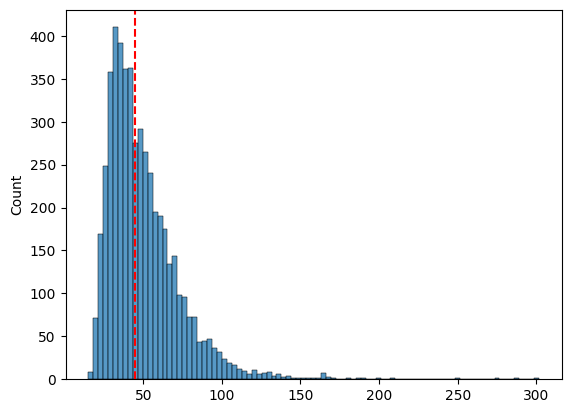

In [50]:
sns.histplot(simulated_values['weight'] * simulated_values['value of time pt'])
plt.axvline(x=(simulated_values['weight'] * simulated_values['value of time pt']).quantile(0.5), color='r', linestyle='--')

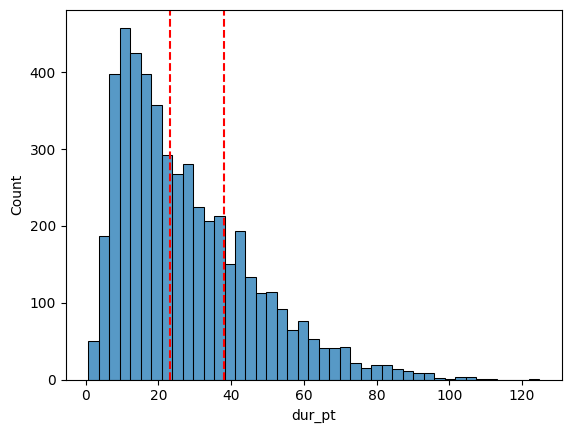

In [51]:
sns.histplot(df["dur_pt"]*60)
plt.axvline(x=df["dur_pt"].quantile(0.5)*60, color='r', linestyle='--')
plt.axvline(x=df["dur_pt"].quantile(0.75)*60, color='r', linestyle='--')

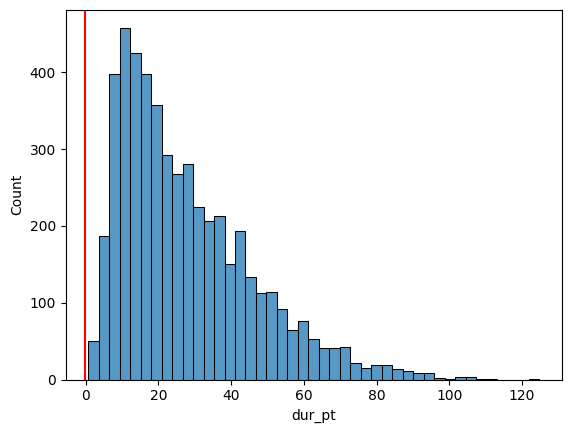

In [ ]:
# sns.histplot(df["dur_walking"])
# sns.histplot(df["dur_cycling"])
sns.histplot(df["dur_pt"]*60)
# sns.histplot(df["dur_driving"])
# plt.xscale('log')
# plt.legend(['Walking', 'Cycling', 'Public transport', 'Driving'])
plt.show()

In [34]:
df

,trip_id,household_id,person_n,trip_n,travel_mode,purpose,fueltype,faretype,bus_scale,survey_year,...,dur_pt_int,pt_interchanges,dur_driving,cost_transit,cost_driving_fuel,cost_driving_ccharge,driving_traffic_percent,dur_pt,cost_driving,seg_age
0,7,0,2,1,4,3,1,3,0.0,1,...,0.000000,0,0.059444,0.0,0.15,0.0,0.112150,0.165000,0.15,0
1,21,5,1,1,4,3,1,5,0.0,1,...,0.000000,0,0.167778,0.0,0.46,0.0,0.243377,0.377500,0.46,1
2,27,7,1,0,4,4,2,1,1.0,1,...,0.100000,1,0.340833,1.5,2.04,0.0,0.280359,0.810556,2.04,1
3,52,12,1,2,4,5,2,1,1.0,1,...,0.094722,1,0.355556,3.0,1.19,0.0,0.249219,0.649167,1.19,1
4,53,12,1,3,4,3,2,1,1.0,1,...,0.000000,0,0.062500,1.5,0.17,0.0,0.124444,0.144444,0.17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,81014,17596,2,0,1,3,6,5,0.0,3,...,0.000000,0,0.108056,0.0,0.25,0.0,0.210797,0.188333,0.25,0
4996,81038,17604,1,4,4,3,5,1,1.0,3,...,0.000000,0,0.157778,1.5,0.55,0.0,0.366197,0.256389,0.55,1
4997,81058,17606,1,0,3,3,6,1,1.0,3,...,0.000000,0,0.278333,1.5,0.65,0.0,0.419162,0.444444,0.65,0
4998,81059,17606,1,2,3,3,6,1,1.0,3,...,0.000000,0,0.281667,1.5,0.63,0.0,0.384615,0.460556,0.63,0


In [65]:
print(f'direct_agg_pt: {direct_agg_pt:.5f} - Direct aggregation for public transport')
print(f'cross_agg_pt_vs_new_car: {cross_agg_pt_vs_new_car:.5f} - Cross aggregation for public transport vs new car')
print(f'cross_agg_pt_vs_walk: {cross_agg_pt_vs_walk:.5f} - Cross aggregation for public transport vs walk')
print(f'cross_agg_pt_vs_cycle: {cross_agg_pt_vs_cycle:.5f} - Cross aggregation for public transport vs cycle')

print(f'direct_agg_new_car: {direct_agg_new_car:.5f} - Direct aggregation for new car')
print(f'cross_agg_new_car_vs_pt: {cross_agg_new_car_vs_pt:.5f} - Cross aggregation for new car vs public transport')
print(f'cross_agg_new_car_vs_walk: {cross_agg_new_car_vs_walk:.5f} - Cross aggregation for new car vs walk')
print(f'cross_agg_new_car_vs_cycle: {cross_agg_new_car_vs_cycle:.5f} - Cross aggregation for new car vs cycle')

print(f'Market shares for walking : {ms_walk:.5f}')
print(f'Market shares for cycling : {ms_cycle:.5f}')
print(f'Market shares for car : {ms_car:.5f}')
print(f'Market shares for pt : {ms_pt:.5f}')

print(f'Mean value of time for car : {vot_car:.5f}')
print(f'Mean value of time for pt : {vot_pt:.5f}')

print(f'Expected revenue for pt (original scenario) : {revenue_pt:.5f}')
print(f'Expected revenue for pt (scneario 2) : {revenue_pt_scen2:.5f}')

direct_agg_pt: -0.06935 - Direct aggregation for public transport
cross_agg_pt_vs_new_car: 0.06930 - Cross aggregation for public transport vs new car
cross_agg_pt_vs_walk: 0.00000 - Cross aggregation for public transport vs walk
cross_agg_pt_vs_cycle: 0.00000 - Cross aggregation for public transport vs cycle
direct_agg_new_car: -0.06504 - Direct aggregation for new car
cross_agg_new_car_vs_pt: 0.05031 - Cross aggregation for new car vs public transport
cross_agg_new_car_vs_walk: 0.00000 - Cross aggregation for new car vs walk
cross_agg_new_car_vs_cycle: 0.00000 - Cross aggregation for new car vs cycle
Market shares for walking : 18.25652
Market shares for cycling : 3.20499
Market shares for car : 42.85942
Market shares for pt : 35.67906
Mean value of time for car : 120.81346
Mean value of time for pt : 50.22594
Expected revenue for pt (original scenario) : 3287.33000
Expected revenue for pt (scneario 2) : 2857.42544


In [ ]:
# We are still using the same model, so no need to estimate it again
'''
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_F2 = Beta('ASC_CYCLE_F2', 0, None, None, 0)
ASC_PT_F2    = Beta('ASC_PT_F2', 0, None, None, 0)
ASC_CAR_F2   = Beta('ASC_CAR_F2', 0, None, None, 0)

# Alternative specific time coefficient
B_TIME_WALK_F2  = Beta('B_TIME_WALK_F2', 0, None, None, 0)
B_TIME_CYCLE_F2 = Beta('B_TIME_CYCLE_F2', 0, None, None, 0)
B_TIME_PT_F2    = Beta('B_TIME_PT_F2', 0, None, None, 0)
B_TIME_CAR_F2   = Beta('B_TIME_CAR_F2', 0, None, None, 0)

# Generic cost coefficient
B_COST_F2 = Beta('B_COST_F2', 0, None, None, 0)

age = Variable('age')
# B_AGE_CYCLE_F2 = Beta('B_AGE_CYCLE_F2', 0, None, None, 0)
B_AGE_PT_F2 = Beta('B_AGE_PT_F2', 0, None, None, 0)
B_AGE_CAR_F2 = Beta('B_AGE_CAR_F2', 0, None, None, 0)
'''

In [ ]:
'''lambda_boxcox_walking = Beta('lambda_boxcox_walking', 1, -10, 10, 0)
boxcox_dur_walking_unrestricted = boxcox(dur_walking, lambda_boxcox_walking)

lambda_boxcox_cycling = Beta('lambda_boxcox_cycling', 1, -10, 10, 0)
boxcox_dur_cycling_unrestricted = boxcox(dur_cycling, lambda_boxcox_cycling)

lambda_boxcox_pt = Beta('lambda_boxcox_pt', 1, -10, 10, 0)
boxcox_dur_pt_unrestricted = boxcox(dur_pt, lambda_boxcox_pt)

lambda_boxcox_driving = Beta('lambda_boxcox_driving', 1, -10, 10, 0)
boxcox_dur_driving_unrestricted = boxcox(dur_driving, lambda_boxcox_driving)'''

In [ ]:
'''V_walk_F2 = (
    B_TIME_WALK_F2 * boxcox_dur_walking_unrestricted
)

V_cycle_F2 = (
    ASC_CYCLE_F2
    # + B_AGE_CYCLE_F2 * age
    + B_TIME_CYCLE_F2 * boxcox_dur_cycling_unrestricted
)

V_pt_F2 = (
    ASC_PT_F2
    + B_AGE_PT_F2 * age
    + B_TIME_PT_F2 * boxcox_dur_pt_unrestricted
    + B_COST_F2 * cost_transit
)

V_car_F2 = (
    ASC_CAR_F2
    + B_AGE_CAR_F2 * age
    + B_TIME_CAR_F2 * boxcox_dur_driving_unrestricted
    + B_COST_F2 * cost_driving
)

V_F2 = {1: V_walk_F2, 2: V_cycle_F2, 3: V_pt_F2, 4: V_car_F2}
logprob_F2 = loglogit(V_F2, None, travel_mode)
biogeme_F2 = bio.BIOGEME(database, logprob_F2)
biogeme_F2.modelName = 'model_F2'

results_F2 = biogeme_F2.estimate()
print(results_F2.print_general_statistics())'''

In [ ]:
'''V_pref = V_F2
results_pref = results_F2'''

In [ ]:
'''mu_motorized = Beta('mu_motorized', 1, 0, None, 0)
motorized = OneNestForNestedLogit(nest_param=mu_motorized, list_of_alternatives=[3, 4], name='motorized')
walk = OneNestForNestedLogit(nest_param=1, list_of_alternatives=[1], name='walk')
bike = OneNestForNestedLogit(nest_param=1, list_of_alternatives=[2], name='bike')
nests = NestsForNestedLogit(choice_set=V_pref, tuple_of_nests=(motorized, walk, bike))'''

In [ ]:
'''logprob_V_F2 = lognested(V_pref, None, nests, travel_mode)
biogeme_V_F2 = bio.BIOGEME(database, logprob_V_F2)
biogeme_V_F2.modelName = 'model_V_F2'
results_V_F2 = biogeme_V_F2.estimate()
print(results_V_F2.print_general_statistics())
print(results_V_F2.print_general_statistics())'''

In [ ]:
'''print('Model V_F2')
display_market_shares(df, V_F2)'''

In [ ]:
#new_cost_transit = 0.8 * cost_transit

In [ ]:
#Value_of_time_car_F2 = - (Derive(V_car_F2, boxcox_dur_driving_unrestricted)) / (Derive(V_car_F2, cost_driving))

In [ ]:
#Value_of_time_pt_F2 = - (Derive(V_pt_F2, boxcox_dur_pt_unrestricted)) / (Derive(V_pt_F2, new_cost_transit))

In [ ]:
'''prob_walk_F2   = nested(V_F2, None, nests, 1)
prob_cycle_F2  = nested(V_F2, None, nests, 2)
prob_pt_F2     = nested(V_F2, None, nests, 3)
prob_car_F2    = nested(V_F2, None, nests, 4) '''

In [ ]:
'''
direct_elas_new_cost_transit = Derive(prob_pt_F2, 'new_cost_transit') * new_cost_transit / prob_pt_F2
cross_elas_pt_vs_cost_driving = Derive(prob_pt_F2, 'cost_driving') * cost_driving / prob_pt_F2
cross_elas_pt_vs_cost_walk = Derive(prob_pt_F2, 'cost_walk') * cost_walk / prob_pt_F2
cross_elas_pt_vs_cost_cycle = Derive(prob_pt_F2, 'cost_cycle') * cost_cycle / prob_pt_F2
direct_elas_cost_driving = Derive(prob_car_F2, 'cost_driving') * cost_driving / prob_car_F2
cross_elas_car_vs_new_cost_transit = Derive(prob_car_F2, 'new_cost_transit') * new_cost_transit / prob_car_F2
cross_elas_car_vs_cost_walk = Derive(prob_car_F2, 'cost_walk') * cost_walk / prob_car_F2
cross_elas_car_vs_cost_cycle = Derive(prob_car_F2, 'cost_cycle') * cost_cycle / prob_car_F2
'''

In [ ]:
'''
weights = get_weights(df)

filters = {
    'female_44_less': (df.age <= 44) & (df.female == 1),
    'female_45_more': (df.age >= 45) & (df.female == 1),
    'male_44_less': (df.age <= 44) & (df.female == 0),
    'male_45_more': (df.age >= 45) & (df.female == 0),
}

# Create a new dataframe to add the market shares in it
df_ms = df.copy()
df_ms['new_cost_transit'] = df_ms['cost_transit'] * 0.8
df_ms['cost_walk'] = 0
df_ms['cost_cycle'] = 0

# Add the weights in the dataframe
for segment_name, segment_rows in filters.items():
    df_ms.loc[segment_rows, 'weight'] = weights[segment_name]

# Useful variables for later
weight = Variable('weight')


simulate = {
    'weight': weight,
    'Prob car': prob_car_F2,
    'Prob public transportation': prob_pt_F2,
    'direct_elas_new_cost_transit': direct_elas_cost_transit,
    'direct_elas_cost_driving': direct_elas_new_cost_driving,
    'cross_elas_pt_vs_cost_driving': cross_elas_pt_vs_new_cost_driving,
    'cross_elas_pt_vs_cost_walk': cross_elas_pt_vs_cost_walk,
    'cross_elas_pt_vs_cost_cycle': cross_elas_pt_vs_cost_cycle,
    'cross_elas_car_vs_new_cost_transit': cross_elas_car_vs_cost_transit,
    'cross_elas_car_vs_cost_walk': cross_elas_car_vs_cost_walk,
    'cross_elas_car_vs_cost_cycle': cross_elas_car_vs_cost_cycle,
}


filename = 'elasticities_2.pickle'
try:
    with open(filename, 'rb') as f:
        simulated_values = pickle.load(f)
        print(f'Elasticities read from {filename}')
except FileNotFoundError:
    biosim = bio.BIOGEME(database, simulate)
    simulated_values = biosim.simulate(results_V_F2.get_beta_values())
    print(f'Elasticities calculated and saved in {filename}')
    with open(filename, 'wb') as f:
        pickle.dump(simulated_values, f)
'''